In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import ternary # ternary plot has a bug
import plotly.express as px
import h5py
import matplotlib as mpl

# import geopandas as gpd

from matplotlib.patches import Circle, Wedge, Polygon

import cmocean # Beautiful colormaps for oceanography
import cmocean.cm as cmo

import os
import matplotlib.patheffects as path_effects


from netCDF4 import Dataset as NetCDFFile 

from obspy.imaging.beachball import beach

# for beachball - there are some error with using obspy
from pyrocko.plot import beachball
from pyrocko import moment_tensor as ptm

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from pathlib import Path
%matplotlib inline

import harmonica as hm

from obspy.core import UTCDateTime

from matplotlib.patches import Polygon

import seaborn as sns
sns.set()
sns.set_style(style='white') 
sns.set_style("ticks", {"xtick.major.size": 0.5, "ytick.major.size": 0.5})

# set the font globally
plt.rcParams.update({'font.family':'Helvetica'})

In [2]:
# earthquakes
data = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/time-series/data/SUeq_data.csv",  header = 'infer')

data.sort_values(by = 'MW', ascending = False, inplace = True)

data['DATE'] = pd.to_datetime(data['DATE']) # change dtype to datetime format
data['DATE'] = data['DATE'].dt.strftime('%Y-%m-%d') # change dtype to object

# data['DATE'] and data['TIME'] should be object (str) to perform + operator

data_dummy = np.array(data['DATE'] + ' ' + data['TIME'])

data_ev_time = []

for val in data_dummy:
    data_ev_time.append(UTCDateTime(val))

    
ref_date = data_ev_time[0]

data_ev_time = np.array(data_ev_time)

date = []

for val in data_ev_time:
    date.append(val - ref_date)
    
date = np.array(date) # this is in seconds

data['YEARS'] = date/31536000

data = data.sort_values(by ='YEARS', ascending=True) # this is an important step
# data = data[(data['DATE'] > '01-01-2003') & (data['DATE'] < '26-11-2004')]

In [3]:
data_mega = data[(data['MW'] >=8.5) & (data['YEARS'] < 3)]

In [4]:
## crustal age

nc = NetCDFFile("/Users/mohd0001/PhD_Monash/Paper1/Data/Mueller2008.nc")

# print(type(nc)) # print the type of the data 
# print(nc.variables.keys()) # check the variables in the data

lat_age = nc.variables['lat'][:]
lon_age = nc.variables['lon'][:]
z_age = nc.variables['z'][:]

# creating meshgrid from our list of spatial coordinates
lon_age, lat_age = np.meshgrid(lon_age,lat_age)

lat_age = nc.variables['lat'][:]
lon_age = nc.variables['lon'][:]
z_age = nc.variables['z'][:]

# creating meshgrid from our list of spatial coordinates
lon_age, lat_age = np.meshgrid(lon_age,lat_age)

In [5]:
# topo
nc = NetCDFFile('topo_sumatra.nc')
# nc = NetCDFFile("/Users/mohd0001/PhD_Monash/Paper1/Data/topo/TopographyWorld.nc")
# print(nc)
lat = nc.variables['lat'][:]
lon = nc.variables['lon'][:]
z = nc.variables['z'][:]
# creating meshgrid from our list of spatial coordinates
lon, lat = np.meshgrid(lon,lat)

In [6]:
# trench
trench_xy = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/time-series/data/plate_boundary.csv")
trench_xy.columns = ['LON', 'LAT'] # column names added

andaman_trench = trench_xy[trench_xy['LAT'] > 6]
sumatra_trench = trench_xy[(trench_xy['LAT'] < 6) & (trench_xy['LAT'] > -1)]
java_trench = trench_xy[(trench_xy['LAT'] < -1)]
# trench_xy.head()

In [7]:
#slab 2.0
slab = NetCDFFile("/Users/mohd0001/PhD_Monash/Paper2/time-series/data/SUslab_depth.grd")
# print(type(slab)) # print the type of the data 
# print(slab.variables.keys()) # print the variables in the data

lon_slab = slab.variables['x'][:]
lat_slab = slab.variables['y'][:]
depth_slab = slab.variables['z'][:]

# creating meshgrid from our list of spatial coordinates
lon_slab, lat_slab = np.meshgrid(lon_slab, lat_slab)

In [8]:
### rupture outline
rup_2004 = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/time-series/data/2004_SUM_rup.csv")
# rup_2004.coulmns = ['LON', 'LAT']

rup_2005 = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/time-series/data/2005_SUM_rup.csv")
# rup_2005.coulmns = ['LON', 'LAT']

rup_2007 = pd.read_csv("/Users/mohd0001/PhD_Monash/Paper2/time-series/data/2007_SUM_rup.csv")
# rup_2007.coulmns = ['LON', 'LAT']

# sum_rup.coulmns = ['LON', 'LAT']
# rup_2005.head()

In [9]:
data_dw = data[(data['CLASS'] == 'DGOING') &
              (data['YEARS'] >= 0) & (data['DEPTH'] > 0)]

## sort by events thrust, normal, strike-slip
# dataT = data_dw[(data_dw['TYPE'] == 'THRUST')]
# dataN = data_dw[(data_dw['TYPE'] == 'NORM')]
# dataS = data_dw[(data_dw['TYPE'] == 'SS')]

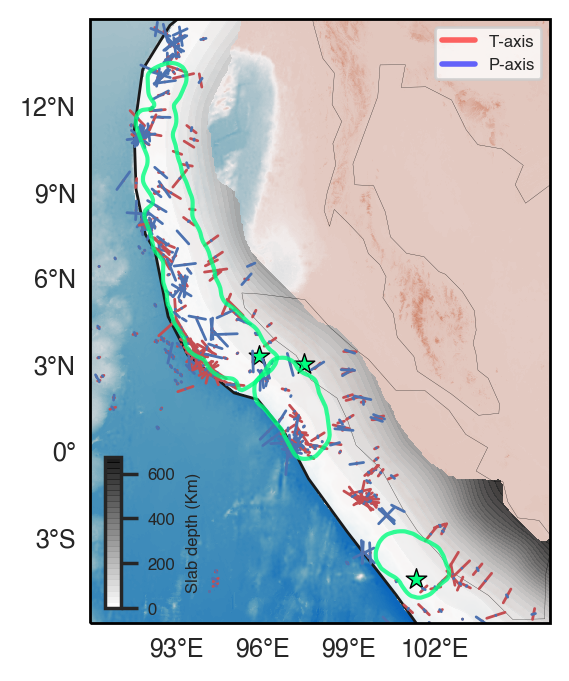

In [10]:
df_to_use = data_dw.reset_index() # very important to reset

proj = ccrs.PlateCarree()

fig, ax = plt.subplots(dpi = 200)
ax = plt.axes(projection = proj)


topo = ax.pcolormesh(lon, lat, z,
                     transform=proj, cmap='cmo.balance', vmin = -9000, vmax = 7000) #tempo

####### slab depth data ######
slab = ax.contourf(lon_slab, lat_slab, depth_slab*-1, 30,
    transform=proj, cmap='binary', alpha = 0.9)

# define slab colorbar
cbaxes = inset_axes(ax, width="3.5%", height="25%", loc=3,
                   bbox_to_anchor=(0,0,1,1), bbox_transform=ax.transAxes)
cbar = plt.colorbar(slab,
             cax=cbaxes, ticks=[0, 200, 400, 600], orientation='vertical')

# define slab colobar label
size=6
cbar.set_label(label='Slab depth (Km)', size=size, weight='bold')
cbar.ax.tick_params(labelsize=size) 


ax.set_extent([90, 106, -6, 15])

ax.coastlines(resolution='110m',
              linewidth = 0.1)                # the level of resolution to render the drawings, 
                                                # see documentation for more details

gl = ax.gridlines(crs=ccrs.PlateCarree()        
                , draw_labels=True              # label coordinates
                , linewidth=0                   # line properties can be changed similar to matplotlib
                , color='black'
                , alpha=0.5
                , linestyle='-')

gl.xlabels_top = False                                           # where labels shouldn't be
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator(np.arange(90,105,3))          # sets longitude tick marks
gl.ylocator = mticker.FixedLocator(np.arange(-6,15,3))          # sets latitude tick marks using numpy module
gl.xformatter = LONGITUDE_FORMATTER                              # set cartopy formatting
gl.yformatter = LATITUDE_FORMATTER

gl.xlabel_style = {'size': 9}                                   # change label font sizes
gl.ylabel_style = {'size': 9}

# plot the trench
ax.plot(trench_xy['LON'], trench_xy['LAT'], '-', c = 'k', linewidth = 1)

# add the T, N, P visualizations
# sine ang dx
t_dx = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.sin(df_to_use['T_AZM']*np.pi/180)
t_dy = 0.4*(np.sin(df_to_use['T_PL']*np.pi/180)**2)*np.cos(df_to_use['T_AZM']*np.pi/180)

n_dx = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.sin(df_to_use['N_AZM']*np.pi/180)
n_dy = 0.4*(np.sin(df_to_use['N_PL']*np.pi/180)**2)*np.cos(df_to_use['N_AZM']*np.pi/180)

p_dx = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.sin(df_to_use['P_AZM']*np.pi/180)
p_dy = 0.4*(np.sin(df_to_use['P_PL']*np.pi/180)**2)*np.cos(df_to_use['P_AZM']*np.pi/180)


for idx, row in df_to_use.iterrows():
    # plot T
    ax.plot([row['LON'] + t_dx[idx], row['LON'] - t_dx[idx]], [row['LAT'] + t_dy[idx], row['LAT'] - t_dy[idx]], '-', linewidth = 1, c = 'r', transform=cartopy.crs.PlateCarree(), alpha = 1)
#     ax.plot([row['LON'] + n_dx[idx], row['LON'] - n_dx[idx]], [row['LAT'] + n_dy[idx], row['LAT'] - n_dy[idx]], '-', linewidth = 1, c = 'g', transform=cartopy.crs.PlateCarree(), alpha = 0.7)
    ax.plot([row['LON'] + p_dx[idx], row['LON'] - p_dx[idx]], [row['LAT'] + p_dy[idx], row['LAT'] - p_dy[idx]], '-', linewidth = 1, c = 'b', transform=cartopy.crs.PlateCarree(), alpha = 1)

    # plot N
    # plot P

 # manual legend
colors = ['red', 'blue']
lines = [Line2D([0], [0], color=c, linewidth=2, linestyle='-', alpha = 0.6) for c in colors]
labels = ['T-axis', 'P-axis']

ax.legend(lines, labels, loc = 'upper right', fontsize = 6)
# plt.text(97.6, 13.7, 'Upper plate stress-state (2 yrs after 2007 ME)', transform=ccrs.PlateCarree(), color='black', fontsize=6, 
#          backgroundcolor ='white', alpha=1)

# plt.text(96, 4, 'Mw 9.0 (2004)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(98.5, 3, 'Mw 8.6 (2005)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(96, -5, 'Mw 8.5 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])
# plt.text(101, -2.5, 'Mw 7.9 (2007)', transform=ccrs.PlateCarree(), color='yellow', fontsize=5, fontstyle='italic', fontweight='bold',
#         path_effects = [path_effects.Stroke(linewidth=1, foreground='black'), path_effects.Normal()])

## Plot Mw ≥ 8.5 megathrust as stars

color= 'springgreen'
ax.scatter(data_mega['LON'], data_mega['LAT'], marker = '*',
           s = 60, c = color, edgecolor = 'black',
           linewidths = 0.5, transform=cartopy.crs.PlateCarree())

###plot rupture patch
ax.plot(rup_2004['LON'], rup_2004['LAT'], '-', c = color, linewidth = 1.5, alpha=0.8)
ax.plot(rup_2005['LON'], rup_2005['LAT'], '-', c = color, linewidth = 1.5, alpha=0.8)
ax.plot(rup_2007['LON'], rup_2007['LAT'], '-', c = color, linewidth = 1.5, alpha=0.8)


# plt.title('Slab before 2004 mainshock', ha='center', fontsize=8)

plt.savefig("/Users/mohd0001/PhD_Monash/Paper2/output/Stress_SP_After.png",
            dpi = 300, transparent= True, bbox_inches='tight')


#m.legend(loc = 'lower left', fontsize = 6)